# Automatic scoring of x-ray images

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import HDF5Matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, \
    Dropout, Lambda, Activation, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
df = pd.read_csv(filepath_or_buffer="/data/deepxray/data/rau_data/merged.csv")
#df = pd.read_csv(filepath_or_buffer="/Volumes/deepxray/data/rau_data/merged.csv")
df = df.loc[df['body_part'].isin(["HAND_LEFT", "HAND_BOTH"])]
df.head()

,id_x,patient_id,date_x,accession_no,scoring_dates,scoring_types,study_iuid,series_iuid,sop_iuid,body_part,...,foot_left_3,foot_left_4,foot_left_5,foot_right_1,foot_right_2,foot_right_3,foot_right_4,foot_right_5,rau_score,creation_date
1,2,1229,2008-08-02,570235,2008-08-02,rau,1.2.276.0.41.10.172.2.26.20080728.66320.2.570235,1.2.392.200046.100.2.1.200050.55991.2008072914...,1.2.392.200046.100.2.1.200050.55991.2008072914...,HAND_BOTH,...,5.0,5.0,15.0,0.0,0.0,5.0,10.0,10.0,33,2010-07-12
3,32486,5776,2006-05-11,1,2006-05-11,rau,1.2.840.113619.6.95.31.0.3.4.1.4099.13.1290030,1.3.46.670589.26.400122.2.20060329.163703.26797,1.2.840.114257.1.8062006.85706.1.1.1,HAND_LEFT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,10,2010-07-12
4,10,469,1983-11-09,NaN,2012-08-21,rau,1.2.276.0.7230010.3.1.2.0.22382.1278840446.382350,1.2.276.0.7230010.3.1.3.0.22382.1278840446.382349,1.2.276.0.7230010.3.1.4.0.22382.1278840446.382351,HAND_BOTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,2012-08-21
6,12,451,1987-02-13,NaN,2012-08-27,rau,1.2.276.0.7230010.3.1.2.0.22391.1278840447.356049,1.2.276.0.7230010.3.1.3.0.22400.1278840448.221664,1.2.276.0.7230010.3.1.4.0.22400.1278840448.221665,HAND_LEFT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62,2012-08-27
7,13,446,1987-08-11,NaN,2012-08-22,rau,1.2.276.0.7230010.3.1.2.0.22409.1278840449.122838,1.2.276.0.7230010.3.1.3.0.22409.1278840449.122837,1.2.276.0.7230010.3.1.4.0.22409.1278840449.122839,HAND_BOTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2012-08-22


In [12]:
clinical = pd.read_csv(filepath_or_buffer="/data/deepxray/data/rau_data/clinical_scores.csv")
clinical = clinical.loc[pd.notnull(clinical['das28bsr_score'])]
clinical.head()

,patient_id,date,physician_global_disease_activity,global_patient_estimate_disease_activity,das28bsr_score,das283crp_score
0,1,2004-10-19,8.0,NaN,6.6,NaN
1,2,2001-10-25,4.0,NaN,6.3,NaN
2,2,2001-11-29,NaN,NaN,4.7,NaN
3,2,2002-03-25,NaN,NaN,6.5,NaN
4,2,2002-09-26,NaN,NaN,3.9,NaN


In [13]:
print(clinical.shape)

(55770, 6)


In [14]:
df = df.merge(right=clinical, left_on=["patient_id", "date_x"], right_on=["patient_id", "date"])

In [15]:
df.head()

,id_x,patient_id,date_x,accession_no,scoring_dates,scoring_types,study_iuid,series_iuid,sop_iuid,body_part,...,foot_right_3,foot_right_4,foot_right_5,rau_score,creation_date,date,physician_global_disease_activity,global_patient_estimate_disease_activity,das28bsr_score,das283crp_score
0,2,1229,2008-08-02,570235,2008-08-02,rau,1.2.276.0.41.10.172.2.26.20080728.66320.2.570235,1.2.392.200046.100.2.1.200050.55991.2008072914...,1.2.392.200046.100.2.1.200050.55991.2008072914...,HAND_BOTH,...,5.0,10.0,10.0,33,2010-07-12,2008-08-02,NaN,NaN,4.3,4.1
1,32486,5776,2006-05-11,1,2006-05-11,rau,1.2.840.113619.6.95.31.0.3.4.1.4099.13.1290030,1.3.46.670589.26.400122.2.20060329.163703.26797,1.2.840.114257.1.8062006.85706.1.1.1,HAND_LEFT,...,0.0,0.0,5.0,10,2010-07-12,2006-05-11,5.0,NaN,5.7,NaN
2,37,1478,1997-12-17,NaN,1997-12-17,rau,1.2.276.0.7230010.3.1.2.0.22630.1278840471.831939,1.2.276.0.7230010.3.1.3.0.22630.1278840471.831938,1.2.276.0.7230010.3.1.4.0.22630.1278840471.831940,HAND_BOTH,...,0.0,0.0,0.0,1,2010-07-12,1997-12-17,0.0,NaN,2.1,NaN
3,41,1756,1997-12-17,NaN,1997-12-17,rau,1.2.276.0.7230010.3.1.2.0.22667.1278840473.756142,1.2.276.0.7230010.3.1.3.0.22667.1278840473.756141,1.2.276.0.7230010.3.1.4.0.22667.1278840473.756143,HAND_BOTH,...,70.0,30.0,10.0,94,2010-07-12,1997-12-17,3.0,NaN,1.4,NaN
4,42,1756,1997-12-17,NaN,1997-12-17,rau,1.2.276.0.7230010.3.1.2.0.22667.1278840473.756142,1.2.276.0.7230010.3.1.3.0.22688.1278840474.814986,1.2.276.0.7230010.3.1.4.0.22688.1278840474.814987,HAND_BOTH,...,70.0,30.0,10.0,94,2010-07-12,1997-12-17,3.0,NaN,1.4,NaN


In [17]:
df.shape

(12232, 55)

In [27]:
names = df["sop_iuid"].as_matrix()

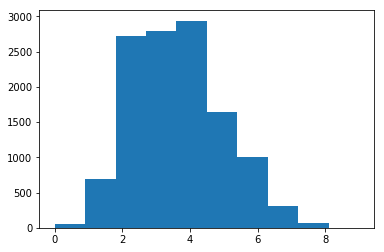

In [20]:
plt.hist(round(df['das28bsr_score'], 0))
plt.show()

In [24]:
root = "/data"
#root = "/Volumes"
dirname = "deepxray/joint_detection/output"

# function to load and preprocess the image
def preprocess_img(xray_name, joint_name):
    # folder name
    folder_name = "predictions_extract_" + joint_name
    # file name
    file_name = xray_name + "_" + joint_name + ".jpg"
    
    # read image
    image = Image.open(fp=os.path.join(root, dirname, folder_name, file_name))
    
    # turn into np array
    data = np.asarray(a=image, dtype="uint8")
    return(data)

In [25]:
# get das-score from dataframe
def get_score(index):
    score = df['das28bsr_score'].as_matrix()[index]
    return(score)

In [30]:
# get patient_id from dataframe
def get_pid(index):
    pid = df["patient_id"].as_matrix()[index]
    return(pid)

In [31]:
# joint names in dataframe
joint_numbers = ["hand_left_1", "hand_left_2", "hand_left_3", "hand_left_4", "hand_left_5", 
                 "hand_left_6", "hand_left_7", "hand_left_8", "hand_left_9", "hand_left_10"]
# corresponding joint names in image names
joint_names = ["pip5", "mcp5", "pip4", "mcp4", "pip3", "mcp3", "mcp2", "pip2", "mcp1", "pip1"]


for i in range(10):
    print(joint_numbers[i] + " -> " + joint_names[i])

hand_left_1 -> pip5
hand_left_2 -> mcp5
hand_left_3 -> pip4
hand_left_4 -> mcp4
hand_left_5 -> pip3
hand_left_6 -> mcp3
hand_left_7 -> mcp2
hand_left_8 -> pip2
hand_left_9 -> mcp1
hand_left_10 -> pip1


In [ ]:
images = []
labels = []
patients = []
n_img = names.shape[0]

for i, xray_name in enumerate(names):
    if (i % 100) == 0:
        clear_output()
        print("Importing images, {0:.2f} % finished".format(i/n_img*100))
        
    for joint in range(10):
        try:
            img = preprocess_img(xray_name, joint_names[joint])
        except Exception: 
            pass
        else:
            lbl = get_score(i)
            if np.isnan(lbl):
                continue
            else:
                images.append(img)
                labels.append(lbl)
                patients.append(get_pid(i))

Importing images, 98.10 % finished


In [33]:
images = np.array(images)
labels = np.array(labels)
patients = np.array(patients)
print(images.shape)
print(labels.shape)
print(patients.shape)

(62649, 150, 150)
(62649,)
(62649,)


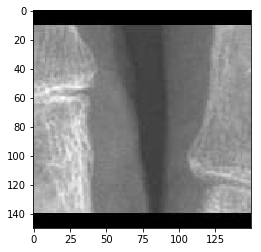

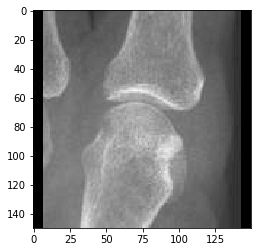

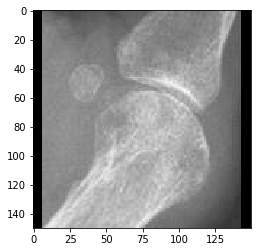

In [34]:
for i in range(3):    
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.show()

In [35]:
with h5py.File('/data/joint_scoring/img_array_das.h5', 'w') as hf:
    hf.create_dataset("img_array",  data=images)
    
with h5py.File('/data/joint_scoring/lbl_array_das.h5', 'w') as hf:
    hf.create_dataset("lbl_array",  data=labels)
    
with h5py.File('/data/joint_scoring/pid_array_das.h5', 'w') as hf:
    hf.create_dataset("pid_array",  data=patients)

In [ ]:
with h5py.File('/data/joint_scoring/img_array.h5', 'r') as hf:
    images = hf['img_array_das'][:]
    
with h5py.File('/data/joint_scoring/lbl_array.h5', 'r') as hf:
    labels = hf['lbl_array_das'][:]
    
with h5py.File('/data/joint_scoring/pid_array.h5', 'r') as hf:
    patients = hf['pid_array_das'][:]

In [36]:
images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)

In [40]:
labels = np.round(labels, 0)
labels = labels.astype("int")
labels

array([4, 4, 4, ..., 2, 2, 2])

In [41]:
img_train = []
labels_train = []
patients_train = []

img_test = []
labels_test = []
patients_test = []

img_val = []
labels_val = []
patients_val = []

indices = np.random.permutation(images.shape[0])
images = images[indices]
labels = labels[indices]
patients = patients[indices]

for i in range(labels.shape[0]):
    
    if (i % 100) == 0:
        clear_output()
        print("Creating test/train/validation split, {0:.2f} % finished".format(i/labels.shape[0]*100))
    
    if patients[i] in patients_train:
        img_train.append(images[i])
        labels_train.append(labels[i])
        patients_train.append(patients[i])
    elif patients[i] in patients_test:
        img_test.append(images[i])
        labels_test.append(labels[i])
        patients_test.append(patients[i])
    elif patients[i] in patients_val:
        img_val.append(images[i])
        labels_val.append(labels[i])
        patients_val.append(patients[i])
    else:
        choice = np.random.choice(a=3, p=[0.7, 0.2, 0.1])
        if choice == 0:
            img_train.append(images[i])
            labels_train.append(labels[i])
            patients_train.append(patients[i])
        elif choice == 1:
            img_test.append(images[i])
            labels_test.append(labels[i])
            patients_test.append(patients[i])
        else:
            img_val.append(images[i])
            labels_val.append(labels[i])
            patients_val.append(patients[i])

Creating test/train/validation split, 99.92 % finished


In [45]:
img_train = np.array(img_train)
labels_train = np.array(labels_train)
patients_train = np.array(patients_train)

img_test = np.array(img_test)
labels_test = np.array(labels_test)
patients_test = np.array(patients_test)

img_val = np.array(img_val)
labels_val = np.array(labels_val)
patients_val = np.array(labels_val)

In [46]:
with h5py.File('/data/joint_scoring/img_train_das.h5', 'w') as hf:
    hf.create_dataset("img_train_das",  data=img_train)
with h5py.File('/data/joint_scoring/img_test_das.h5', 'w') as hf:
    hf.create_dataset("img_test_das",  data=img_test)
with h5py.File('/data/joint_scoring/img_val_das.h5', 'w') as hf:
    hf.create_dataset("img_val_das",  data=img_val)

with h5py.File('/data/joint_scoring/labels_train_das.h5', 'w') as hf:
    hf.create_dataset("labels_train_das",  data=labels_train)
with h5py.File('/data/joint_scoring/labels_test_das.h5', 'w') as hf:
    hf.create_dataset("labels_test_das",  data=labels_test)
with h5py.File('/data/joint_scoring/labels_val_das.h5', 'w') as hf:
    hf.create_dataset("labels_val_das",  data=labels_val)
    
with h5py.File('/data/joint_scoring/patients_train_das.h5', 'w') as hf:
    hf.create_dataset("patients_train_das",  data=patients_train)
with h5py.File('/data/joint_scoring/patients_test_das.h5', 'w') as hf:
    hf.create_dataset("patients_test_das",  data=patients_test)
with h5py.File('/data/joint_scoring/patients_val_das.h5', 'w') as hf:
    hf.create_dataset("patients_val_das",  data=patients_val)

In [151]:
with h5py.File('/data/joint_scoring/labels_train_das.h5', 'r') as hf:
    labels_train = hf['labels_train_das'][:]

with h5py.File('/data/joint_scoring/labels_test_das.h5', 'r') as hf:
    labels_test = hf['labels_test_das'][:]
    
with h5py.File('/data/joint_scoring/labels_val_das.h5', 'r') as hf:
    labels_val = hf['labels_val_das'][:]

In [152]:
labels_train[labels_train == 9] = 8
labels_test[labels_test == 9] = 8
labels_val[labels_val == 9] = 8

In [153]:
print(np.unique(labels_train))
print(np.unique(labels_test))
print(np.unique(labels_val))

[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]


In [154]:
# define class weights because of imbalance
weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                 classes=np.unique(labels_train), 
                                                 y=labels_train)

print(max(weights)/min(weights))

weights = dict(enumerate(weights))
print(weights)

48.7440758294
{0: 18.3113645965357, 1: 1.7230371695487974, 2: 0.46824393669313458, 3: 0.47928830502476999, 4: 0.488575518807841, 5: 0.83594669135373878, 6: 1.4598026337947527, 7: 5.8445253505933117, 8: 22.824117956819379}


In [155]:
# model.fit does not work with class_weights for a HDF5 Matrix
# therefore, create sample weights

sample_weights = [ weights[x] for x in labels_train ]

sample_weights = np.array(sample_weights)

In [156]:
# one hot encode outputs
labels_train_onehot = LabelBinarizer().fit_transform(labels_train)
labels_test_onehot = LabelBinarizer().fit_transform(labels_test)
labels_val_onehot = LabelBinarizer().fit_transform(labels_val)
num_classes = labels_train_onehot.shape[1]
print(num_classes)

9


In [157]:
labels_train_onehot.shape

(43343, 9)

In [158]:
labels_train_onehot[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 0])

In [159]:
with h5py.File('/data/joint_scoring/labels_train_onehot_das.h5', 'w') as hf:
    hf.create_dataset("labels_train_onehot_das",  data=labels_train_onehot)
with h5py.File('/data/joint_scoring/labels_test_onehot_das.h5', 'w') as hf:
    hf.create_dataset("labels_test_onehot_das",  data=labels_test_onehot)
with h5py.File('/data/joint_scoring/labels_val_onehot_das.h5', 'w') as hf:
    hf.create_dataset("labels_val_onehot_das",  data=labels_val_onehot)

Import data as HDF5 Matrix

In [160]:
img_train = HDF5Matrix('/data/joint_scoring/img_train_das.h5', 'img_train_das')
img_test = HDF5Matrix('/data/joint_scoring/img_test_das.h5', 'img_test_das')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_onehot_das.h5', 'labels_train_onehot_das')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_onehot_das.h5', 'labels_test_onehot_das')

In [161]:
labels_train.shape

(43343, 10)

In [162]:
labels_train[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

## 2. Model

In [108]:
def conv_model():
    # create model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255., input_shape=(150, 150, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=num_classes, activation="softmax",
                    kernel_initializer="he_normal"))

    # Compile model
    model.compile(optimizer="adam", loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [109]:
# build the model
model = conv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_71 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
activation_71 (Activation)   (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_72 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
activation_72 (Activation)   (None, 150, 150, 32)      0         
__________

In [55]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [56]:
print(new_folder)

20171204_101221


In [57]:
desc = "Predicting DAS scores"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [58]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [163]:
# Fit the model
model.fit(x=img_train, y=labels_train_onehot, batch_size=100, epochs=25, verbose=1,
          callbacks=[tb_callback], validation_data=(img_test, labels_test_onehot),
          shuffle="batch", sample_weight=sample_weights)

Train on 43343 samples, validate on 13122 samples
Epoch 1/25
43343/43343 [==============================] - 91s - loss: 2.3775 - acc: 0.1028 - val_loss: 2.2542 - val_acc: 0.0730
Epoch 2/25
43343/43343 [==============================] - 89s - loss: 2.2375 - acc: 0.0800 - val_loss: 2.1619 - val_acc: 0.0546
Epoch 3/25
43343/43343 [==============================] - 89s - loss: 2.1918 - acc: 0.0650 - val_loss: 2.1846 - val_acc: 0.0275
Epoch 4/25
43343/43343 [==============================] - 89s - loss: 2.1672 - acc: 0.0613 - val_loss: 2.2136 - val_acc: 0.1061
Epoch 5/25
43343/43343 [==============================] - 89s - loss: 2.1538 - acc: 0.0576 - val_loss: 2.1831 - val_acc: 0.0341
Epoch 6/25
43343/43343 [==============================] - 89s - loss: 2.1366 - acc: 0.0614 - val_loss: 2.2594 - val_acc: 0.0163
Epoch 7/25
43343/43343 [==============================] - 89s - loss: 2.1484 - acc: 0.0595 - val_loss: 2.1444 - val_acc: 0.0434
Epoch 8/25
43343/43343 [==============================

In [164]:
# Final evaluation of the model
scores = model.evaluate(img_test, labels_test, verbose=0)
print("Error: %.2f%%" % (100 - scores[1] * 100))

Error: 92.23%


In [165]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [166]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict_classes(img_test)
p = model.predict_proba(img_test)

print(classification_report(np.argmax(labels_test, axis=1), pred))
cnf_matrix = confusion_matrix(np.argmax(labels_test, axis=1), pred)
print(cnf_matrix)

13088/13122 [============================>.] - ETA: 0s             precision    recall  f1-score   support

          0       0.01      0.53      0.03        95
          1       0.10      0.20      0.13       880
          2       0.29      0.10      0.15      3234
          3       0.23      0.09      0.13      2903
          4       1.00      0.00      0.00      3319
          5       0.00      0.00      0.00      1223
          6       0.09      0.13      0.10      1119
          7       0.03      0.11      0.05       271
          8       0.01      0.46      0.02        78

avg / total       0.39      0.08      0.08     13122

[[ 50  10   8   4   0   0  15   2   6]
 [279 174  78  91   0   0  79  41 138]
 [867 519 327 303   0   2 473 161 582]
 [761 431 298 257   0   2 381 156 617]
 [881 399 261 262   1   0 385 220 910]
 [235 105  70  91   0   0 166 130 426]
 [221  89  86  83   0   1 146 123 370]
 [ 45   8  14  30   0   0  24  29 121]
 [  8   2   4   2   0   1   9  16  36]]


Confusion matrix, without normalization
[[ 50  10   8   4   0   0  15   2   6]
 [279 174  78  91   0   0  79  41 138]
 [867 519 327 303   0   2 473 161 582]
 [761 431 298 257   0   2 381 156 617]
 [881 399 261 262   1   0 385 220 910]
 [235 105  70  91   0   0 166 130 426]
 [221  89  86  83   0   1 146 123 370]
 [ 45   8  14  30   0   0  24  29 121]
 [  8   2   4   2   0   1   9  16  36]]
Normalized confusion matrix
[[  5.26315789e-01   1.05263158e-01   8.42105263e-02   4.21052632e-02
    0.00000000e+00   0.00000000e+00   1.57894737e-01   2.10526316e-02
    6.31578947e-02]
 [  3.17045455e-01   1.97727273e-01   8.86363636e-02   1.03409091e-01
    0.00000000e+00   0.00000000e+00   8.97727273e-02   4.65909091e-02
    1.56818182e-01]
 [  2.68089054e-01   1.60482375e-01   1.01113173e-01   9.36920223e-02
    0.00000000e+00   6.18429190e-04   1.46258503e-01   4.97835498e-02
    1.79962894e-01]
 [  2.62142611e-01   1.48467103e-01   1.02652429e-01   8.85291078e-02
    0.00000000e+00   6.8894247

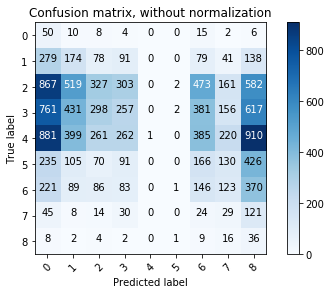

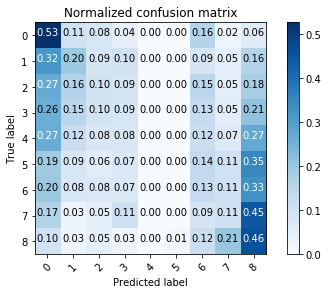

In [167]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [168]:
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Mean accuracy per class")
print(np.mean(np.diag(cm)))

Mean accuracy per class
0.179223311884


In [169]:
upper = np.diag(cm, 1)
upper = np.append(upper, 0)
diagonal = np.diag(cm)
lower = np.diag(cm, -1)
lower = np.append(0, lower)

arr = np.vstack((upper, diagonal, lower))
print("Mean accuracy in the correct class or +- 1")
print(arr.sum(axis=0).mean())

Mean accuracy in the correct class or +- 1
0.394049959665


In [171]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray_das_scores.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)